# Predicting the 2016 US Election Results (in Hindsight) 
 
## Background 
 
The results of the election season 2016 caught many people by surprise. Even with ever improving quantity **and** quality in polling data and statistical analyses of these, predictions failed to foresee a Trump win. Admittedly, just looking at the popular vote, fivethirtyeight gave Clinton 48.5% and Trump 44.9% just before Election Day. The final results are not far off with 48.2% for Clinton and 46.1% for Trump. Yet, overall the upset was a significant one mainly due to the Electoral College system.

## Goal 

Surprised - like most everyone else - by the final results of the 2016 Election, I wanted to dig deeper into the election results, in an attempt to understand the outcome a little more. 

The goals of this study are twofold:

1) To explore correlations between demographic and census statistics in US counties and this county's tendency to vote for a particular candidate in the 2016 US election. 

2) If the data exploration shows census statistics that correlate well with the vote share of one candidate, then employ machine-learning algorithms to predict which counties will vote for Trump.

## Data Sets

To adequately address these questions, I made use of the following two data sets:

1) 2016 US Election results on a county level. I found these data on github (https://github.com/mkearney/presidential_election_county_results_2016). It is a 1.7 MByte .csv file with the relative vote share for every candidate in every county of the United States.

2) US Census statistics for every county in the United States, as downloaded from kaggle (https://www.kaggle.com/benhamner/2016-us-election).

### Importing necessary packages and loading data sets

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy    
from matplotlib import patches

import seaborn as sns
    
results = pd.read_csv('pres16results.csv')
counties = pd.read_csv('county_facts (1).csv')

counties.head(4)

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,0,United States,NaN,318857056,308758105,3.3,308745538,6.2,23.1,14.5,...,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,NaN,4849377,4780127,1.4,4779736,6.1,22.8,15.3,...,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6


In [2]:
results.head(4)

,county,fips,cand,st,pct_report,votes,total_votes,pct,lead
0,NaN,US,Donald Trump,US,0.9951,60350241.0,127592176.0,0.472993,Donald Trump
1,NaN,US,Hillary Clinton,US,0.9951,60981118.0,127592176.0,0.477938,Donald Trump
2,NaN,US,Gary Johnson,US,0.9951,4164589.0,127592176.0,0.032640,Donald Trump
3,NaN,US,Jill Stein,US,0.9951,1255968.0,127592176.0,0.009844,Donald Trump


## Data cleaning

Note that the election results dataframe also contains results on federal and state level. Since I will only focus on counties, I will clean this dataframe up by deleting state-wide and federal results. 

I will first create a list with items that need to be exluded from the results dataframe and then iterate over the list and remove each otem from the dataframe.

In [3]:
excl_list = ['US', 'CA', 'FL', 'TX', 'NY', 'PA', 'IL', 'OH', 'MI', 'NC', 'GA', 'VA', 'NJ', 'MA', 'WI', 'MN', 'MO', 'WA', 'IN', 'CO', 'TN', 'MD', 'SC', 'AL', 'AZ', 'LA', 'KY', 'OR', 'CT', 'IA', 'OK', 'MS', 'NV', 'AR', 'UT', 'NE', 'NM', 'ME', 'NH', 'WV', 'ID', 'MT', 'KS', 'RI', 'DE', 'HI', 'SD', 'ND', 'VT', 'DC', 'WY', 'AK'] 

# now remove all the states from the counties list
for state in excl_list:
    results = results[results.fips != state]

For all future use, we need to join both dataframes together to have all relevant information in one place.

In [4]:
# We need one table/data frame for proper data manipulation extraction.
# So we have to perform a join on both data frames. The one key that both have in common is the county ID (fips)
# The fips column in the results dataframe is of type 'object'. 
# It needs to be of type int64 (like the one in counties) to perform the merge on 'fips'. Let's change that!
results['fips'] = results['fips'].astype(int)

# Perform a merge of the two dataframes, so that we got all data we need in one 
merged = pd.merge(left=counties,right=results, how='inner', left_on='fips', right_on='fips')

# Get a dataframe with only the relevant election results and census statistics
demo = merged[['fips', 'cand', 'lead', 'pct', 'EDU685213', 'EDU635213', 'POP815213', 'POP645213', 'RHI825214', 'RHI725214', 'RHI425214', 'RHI225214', 'RHI125214', 'HSG495213', 'INC910213', 'INC110213', 'PVY020213', 'POP060210']]

# Get a dataframe with only the rows that have Trump as candidate
trump = demo[demo.cand == 'Donald Trump']

The column names for our county statistics are rather cryptic. I will create a dictionary to map these to more meaningful ones.

In [5]:
# Create the dictionary
county_dict = {'EDU685213' : '% Bachelor\'s Degree', 
               'EDU635213' : '% High School or Higher',
               'POP815213' : '% Lang Other Than Engl at Home',
               'POP645213' : '% Foreign Born',
               'RHI825214' : '% White (Non Hispanic)',
               'RHI725214' : '% Hispanic',
               'RHI425214' : '% Asian',
               'RHI225214' : '% Black',
               'RHI125214' : '% White (Incl. Hispanic)',
               'HSG495213' : 'Median Housing Value',
               'INC910213' : 'Income (Per Capita)',
               'INC110213' : 'Household Income (Median)',
               'PVY020213' : '% Persons Below Poverty Level',
               'POP060210' : 'Population/Square Mile'
              }

# Rename columns values to something more meaningful
trump.rename(columns = county_dict, inplace = True)

/Users/stefan/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


I would like to treat this problem as a classification problem, trying to predict for each county whether Trump won or not. In order to apply machine-learning to this problem, we need a numeric binary label (0 for a Trump loss, 1 for a win).

Therefore, as a final data cleaning step, I am going to add an additional column to the dataframe that will be called 'win' and is either 0 or 1.

In [6]:
# Initialize to 0
trump['win'] = 0

# Set 1 if Trump won, i.e., column 'lead' says 'Donald Trump'
trump['win'][trump['lead'] == 'Donald Trump'] = 1

/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/stefan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stefan/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:4702: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_d

## Data Exploration

After cleaning all data, we have it in perfect shape for analysis. Let's explore correlations between several interesting county statistics and that county's election result, as exressed by %Trump vote share.

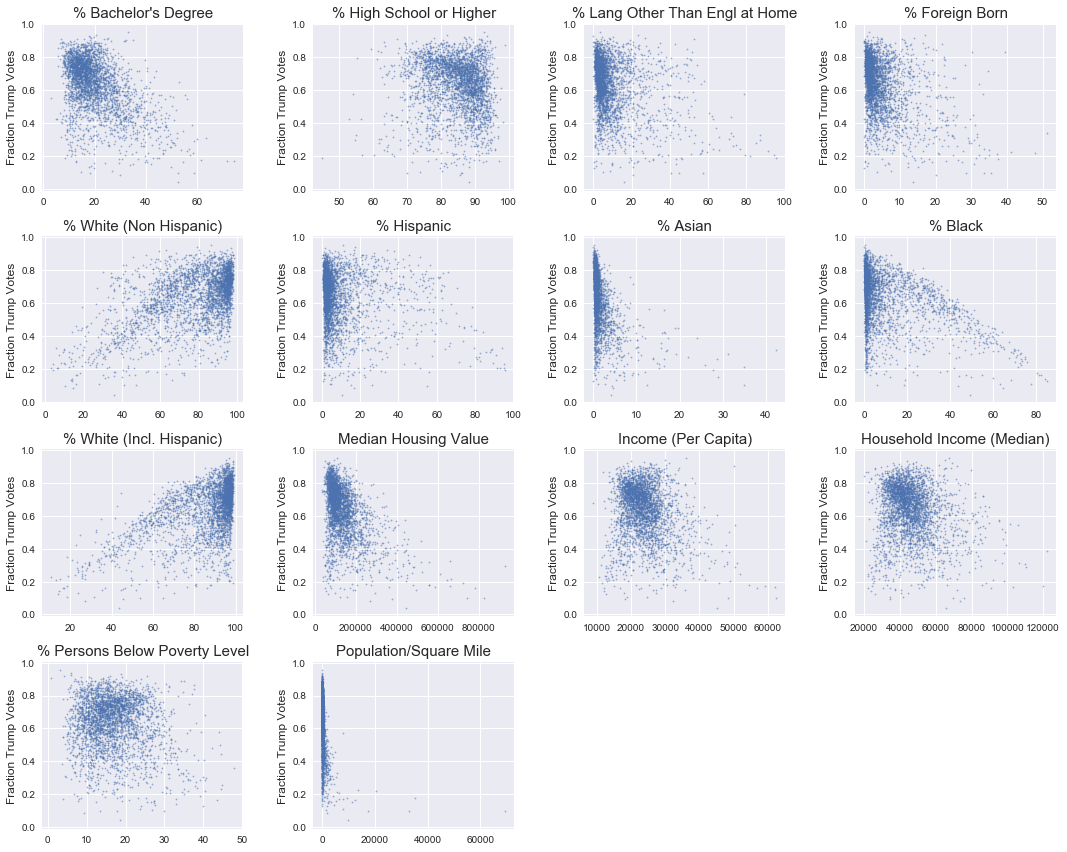

In [7]:
# Plot Trump percentages against census statistics
plt.figure(figsize=(15, 12))
for ii, col in enumerate(trump.columns[4:-1]):
    plt.subplot(4, 4, ii+1)
    plt.tick_params(labelsize = 10)
    plt.title(col, fontsize = 15)
    plt.scatter(trump[col], trump['pct'], alpha = 0.5, s = 1.8)
    plt.ylabel('Fraction Trump Votes', fontsize=12)
    
plt.tight_layout()

Some statistics do seem to correlate relatively well with Trump percentages. Mainly race and education seem to play a big role. The plot of % Bachelor's degree vs. pct implies that people with higher education tend to vote less likely for Trump. Also, the higher the %White in a county, the liklier that county is to vote for Trump, and the reverse effect with %Black and similarly so with %Asian. 

Another interesting correlation seems to be between housing vaues and Tump votes, where counties with higher median housing values seem to vote less likely for Trump.

Also, less densely populated counties are more likely to vote for Trump, and this decrease seems to be of exponential nature.

Lastly, counties with higher percentages of foreign born people, vote less likely for Trump.

In summary, counties that are more diverse, more educated and more densely populated voted less likely for Trump. This agrees well with the notion that is commonly heard in the media that rural white voters cost Clinton a victory that had already been predicted to be for certain by many news outlets. Given that one of Trumps campaign focus was to appeal to exactly these voter groups (rural, white, less educated), one might congratulate his campaign for being successful in that regard and to have focued on the correct targets.

## Exploring Correlations

To get a more quantitative view of these correlations, we can calculate pearson correlation coefficients between the variables in our dataframe, and plot it in form of a heatmap, where more intense colors represent higher correlations.

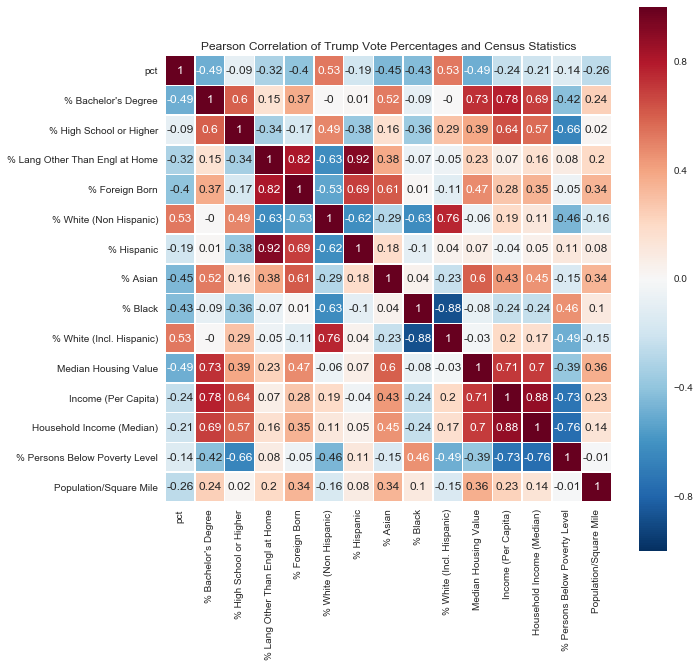

In [8]:
f, ax = plt.subplots(figsize=(10, 10))

plt.title('Pearson Correlation of Trump Vote Percentages and Census Statistics')
sns.set(font_scale=1)
sns.heatmap(trump.loc[:,'pct':'Population/Square Mile'].astype(float).corr().round(decimals = 2), linewidths = 0.5, vmax = 1.0, square = True, 
            annot = True, annot_kws={"size": 12})


Lastly, another way to visualize how counties that voted for Trump differ from those that voted for Clinton, is to plot histograms, counting for each county statistic how many

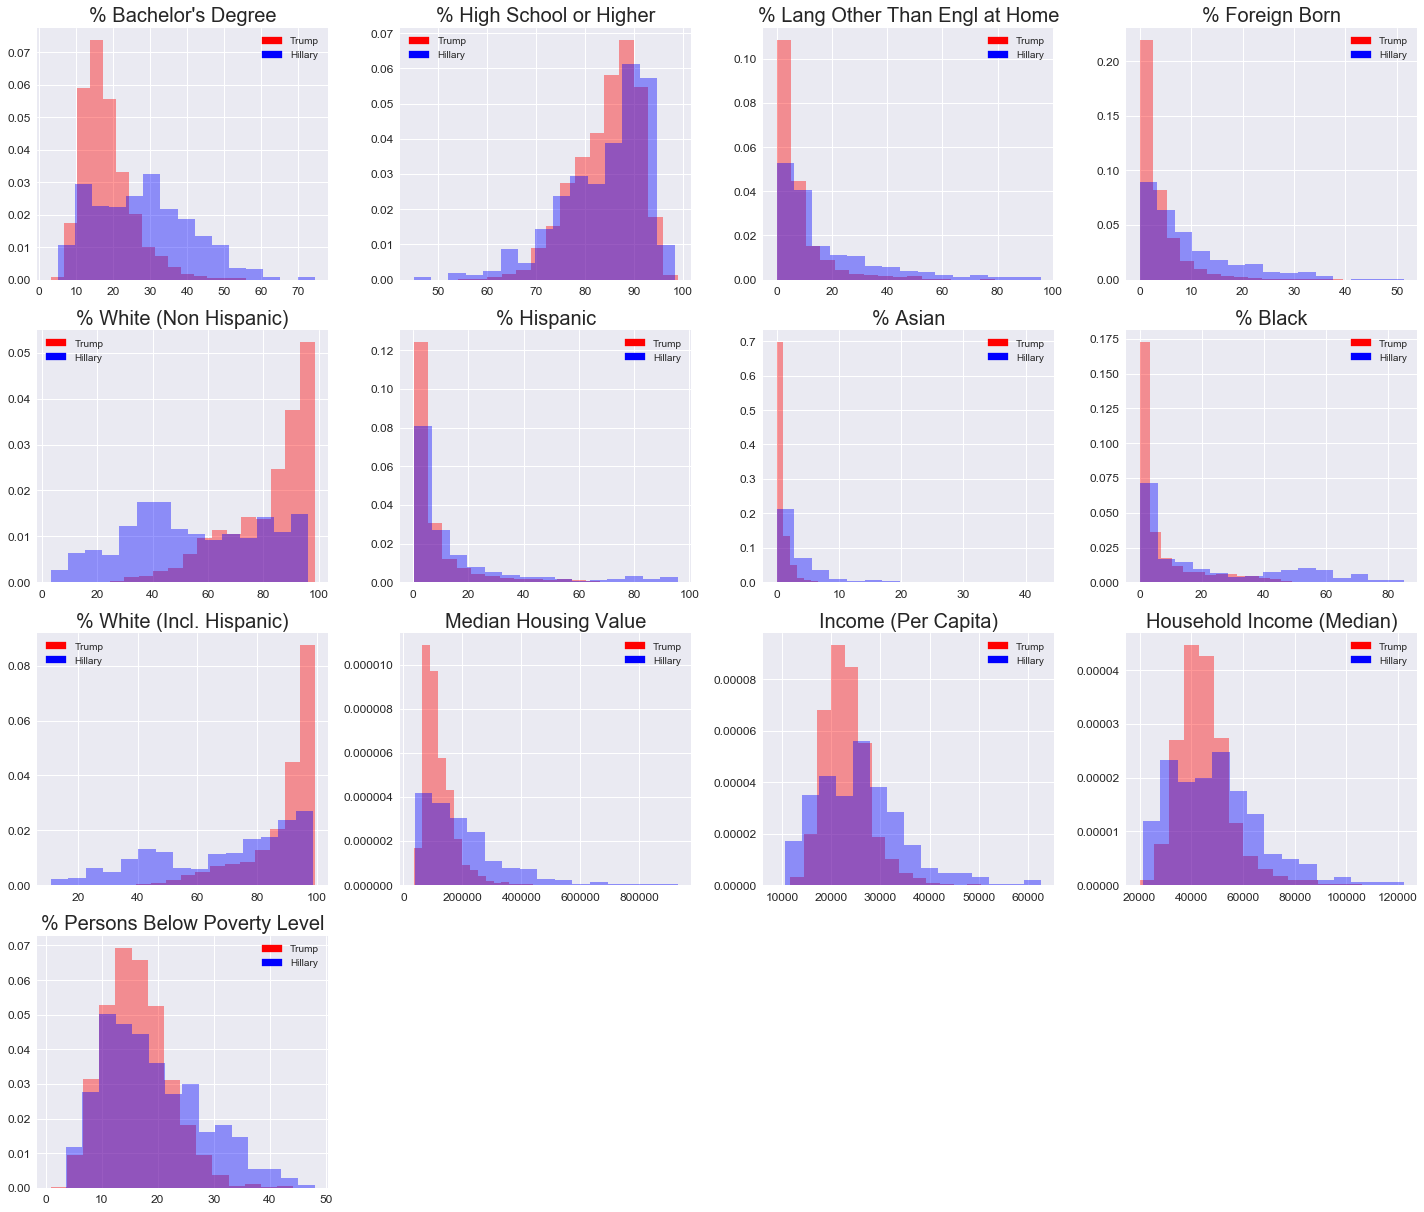

In [9]:
plt.figure(figsize=(20, 17))
for ii, col in enumerate(trump.columns[4:-2]):
    plt.subplot(4 ,4, ii+1)
    plt.tick_params(labelsize = 12)
    plt.title(col, fontsize = 20)
    
    plt.legend(handles = [patches.Patch(label = 'Trump', color='red'),
                          patches.Patch(label = 'Hillary', color='blue')])
    plt.hist(trump[trump['lead'] == 'Donald Trump'][col], stacked=True, normed = True, color='red', alpha = 0.4, bins = 15)
    plt.hist(trump[trump['lead'] != 'Donald Trump'][col], stacked=True, normed = True, color='blue', alpha = 0.4, bins = 15)
    
plt.tight_layout()

## Preparing Data for Machine Learning

The data has already been cleaned, so I just need to prepare them to be fed into machine-learning algorithms.

We need to:

1) Split the data in a training and test data set, to check how well the model performs outisde of the training data, to prevent overfitting.

2) Extract feature and label vectors.

In [10]:
# Import the necessary libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
train, test = train_test_split(trump, test_size = 0.3, random_state = 42)

# Extract feature vector
X_test = test.ix[:,4:-1]
X_train = train.ix[:,4:-1]

# Scaling the data
X_test_scale = preprocessing.scale(X_test)
X_train_scale = preprocessing.scale(X_train)

# Normalizing the data
X_test_norm = preprocessing.normalize(X_test)
X_train_norm = preprocessing.normalize(X_train)

# Extract label vector
y_test = test[['win']].values.ravel()
y_train = train[['win']].values.ravel()

## Machine Learning

Now that the data is ready to be fed into our models, we need to choose a suitable model. Since I want to approach this problem as a binary classification case, several possible models come to mind:

- Decision Tree 
- Random Forests
- Logistic Regression
- k-nearest Neighbors (kNN)

### Decision Tree Model

In [11]:
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fitting the model with our training data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# make predictions
expected = y_test
predicted = model.predict(X_test)
predicted_train = model.predict(X_train)

# summarize the fit of the model
print('\n---------------------------------')
print('Training Score')
print(metrics.accuracy_score(y_train, predicted_train))
print('\n---------------------------------')
print('Classification Report Training Set:')
print(metrics.classification_report(y_train, predicted_train))
print('\n---------------------------------')
print('Confusion Matrix Training Set:')
print(metrics.confusion_matrix(y_train, predicted_train))
print('\n---------------------------------')
print('Test Score')
print(metrics.accuracy_score(expected, predicted))
print('\n---------------------------------')
print('Classification Report Test Set:')
print(metrics.classification_report(expected, predicted))
print('\n---------------------------------')
print('Confusion Matrix Test Set:')
print(metrics.confusion_matrix(expected, predicted))
print('\n---------------------------------')
print('Feature Importance: ')
print(model.feature_importances_)


---------------------------------
Training Score
1.0

---------------------------------
Classification Report Training Set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       343
          1       1.00      1.00      1.00      1835

avg / total       1.00      1.00      1.00      2178


---------------------------------
Confusion Matrix Training Set:
[[ 343    0]
 [   0 1835]]

---------------------------------
Test Score
0.904710920771

---------------------------------
Classification Report Test Set:
             precision    recall  f1-score   support

          0       0.67      0.75      0.71       143
          1       0.95      0.93      0.94       791

avg / total       0.91      0.90      0.91       934


---------------------------------
Confusion Matrix Test Set:
[[107  36]
 [ 53 738]]

---------------------------------
Feature Importance: 
[ 0.23733071  0.01659328  0.00561992  0.03810891  0.29654241  0.05026581
  0.037781

### Random Forest Model

In [12]:
from sklearn.ensemble import RandomForestClassifier 

# fitting the model with our training data
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# make predictions
expected = y_test
predicted = model.predict(X_test)
predicted_train = model.predict(X_train)

print('\n---------------------------------')
print('Training Score')
print(metrics.accuracy_score(y_train, predicted_train))
print('\n---------------------------------')
print('Classification Report Training Set:')
print(metrics.classification_report(y_train, predicted_train))
print('\n---------------------------------')
print('Confusion Matrix Training Set:')
print(metrics.confusion_matrix(y_train, predicted_train))
print('\n---------------------------------')
print('Test Score')
print(metrics.accuracy_score(expected, predicted))
print('\n---------------------------------')
print('Classification Report Test Set:')
print(metrics.classification_report(expected, predicted))
print('\n---------------------------------')
print('Confusion Matrix Test Set:')
print(metrics.confusion_matrix(expected, predicted))
print('\n---------------------------------')
print('Feature Importance: ')
print(model.feature_importances_)


---------------------------------
Training Score
1.0

---------------------------------
Classification Report Training Set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       343
          1       1.00      1.00      1.00      1835

avg / total       1.00      1.00      1.00      2178


---------------------------------
Confusion Matrix Training Set:
[[ 343    0]
 [   0 1835]]

---------------------------------
Test Score
0.949678800857

---------------------------------
Classification Report Test Set:
             precision    recall  f1-score   support

          0       0.84      0.83      0.83       143
          1       0.97      0.97      0.97       791

avg / total       0.95      0.95      0.95       934


---------------------------------
Confusion Matrix Test Set:
[[118  25]
 [ 22 769]]

---------------------------------
Feature Importance: 
[ 0.12322888  0.03150406  0.04207787  0.04603513  0.13644157  0.04354755
  0.082862

### Logistic Regression


In [13]:
# Import necessary packages for Logistic Regression
from sklearn import linear_model, datasets
from sklearn.model_selection import cross_val_score

# fitting the model with our training data
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

# make predictions
expected = y_test
predicted = model.predict(X_test)
predicted_train = model.predict(X_train)

# summarize the fit of the model
print('\nScore for the Training Set:')
print(model.score(X_train, y_train))
print('\nScore for the Test Set:')
print(model.score(X_test, y_test))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


Score for the Training Set:
0.928374655647

Score for the Test Set:
0.927194860814
             precision    recall  f1-score   support

          0       0.82      0.68      0.74       143
          1       0.94      0.97      0.96       791

avg / total       0.92      0.93      0.92       934

[[ 97  46]
 [ 22 769]]


The logistic regression model correcty identifies 97% of Trump wins, with an overall score for the test set of 93%. The training error is nearly identical.

Now, we can go ahead and predict probabilities for Trump winning any given county, e.g., San Mateo County (fips: 6081) or Santa Clara county (fips: 6085):

In [14]:
print('San Mateo County: 19% Trump Vote:')
print(model.predict_proba(trump[trump.fips == 6081].ix[:,4:-1]))

print('\nSarpy County, NE: 56% Trump Vote:')
print(model.predict_proba(trump[trump.fips == 31153].ix[:,4:-1]))

print('\nSanta Clara County: 21% Trump Vote:')
print(model.predict_proba(trump[trump.fips == 6085].ix[:,4:-1]))

San Mateo County: 19% Trump Vote:
[[  9.99993107e-01   6.89330183e-06]]

Sarpy County, NE: 56% Trump Vote:
[[ 0.04543071  0.95456929]]

Santa Clara County: 21% Trump Vote:
[[  9.99968876e-01   3.11242704e-05]]


Not surprisingly, a very liberal, highly educated and very diverse county like San Mateo or Santa Clara, predicted to have a 99.99% probability of voting against Trump, which is in agreement with the eventual outcome of the election with 19% and 21% Trump votes in San Mateo and Santa Clara, respectively.

### k-Nearest Neighbors

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# fit data to k-Nearest Neighbor (kNN) model
model = KNeighborsClassifier()
model.fit(X_train, y_train)

# make predictions
expected = y_test
predicted = model.predict(X_test)

# summarize the fit of the model
print('\nScore for the Training Set:')
print(model.score(X_train, y_train))
print('\nScore for the Test Set:')
print(model.score(X_test, y_test))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


Score for the Training Set:
0.882920110193

Score for the Test Set:
0.866167023555
             precision    recall  f1-score   support

          0       0.60      0.37      0.46       143
          1       0.89      0.96      0.92       791

avg / total       0.85      0.87      0.85       934

[[ 53  90]
 [ 35 756]]


In contrast to the previously used models, the kNN model performs poorly. Especially Trum losses (win: 0), are predicted very poorly (at 37% recall).

Since kNN optimizes distances between features in euclidian space in order to classify, it is extremely susceptible to features not being on the same scale.

Let's try to use scale data, and see if that alleviates the problem.

In [16]:
# fit data to k-Nearest Neighbor (kNN) model
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

# make predictions
expected = y_test
predicted = model.predict(X_test_scale)

# summarize the fit of the model
print('\nScore for the Training Set:')
print(model.score(X_train_scale, y_train))
print('\nScore for the Test Set:')
print(model.score(X_test_scale, y_test))
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))


Score for the Training Set:
0.953168044077

Score for the Test Set:
0.932548179872
             precision    recall  f1-score   support

          0       0.82      0.71      0.76       143
          1       0.95      0.97      0.96       791

avg / total       0.93      0.93      0.93       934

[[102  41]
 [ 22 769]]


Using scale data indeed solved the problem of our underperforming kNN model. In fact, with 93% it performs second best so far. However, the test score is smaller than the training error. There is some overfitting.

Let's see whether we can optimize the performance of our model by tweaking the most important parameters in a kNN model, k, the number of nearest neighbours to be considered.

We can build a loop that goes from k 1 to 100 and measures the training and testing score of the model with different values of k.

Then we can plot these scores against the value of k.

15


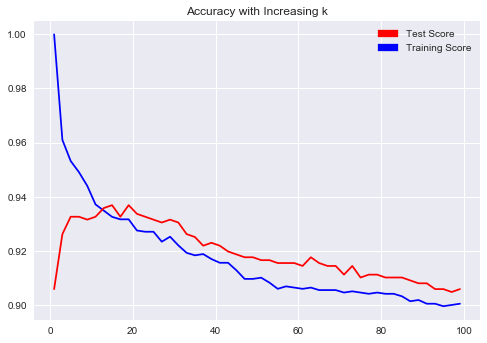

In [17]:
ks = []
accuracies_test = []
accuracies_train = []
for k in range(1, 100, 2):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_scale, y_train)
    accuracy_test = clf.score(X_test_scale, y_test)
    accuracy_train = clf.score(X_train_scale, y_train)
    ks.append(k)
    accuracies_test.append(accuracy_test)
    accuracies_train.append(accuracy_train)

plt.plot(ks, accuracies_train, color = 'blue')
plt.plot(ks, accuracies_test, color = 'red')
plt.legend(handles = [patches.Patch(label = 'Test Score', color = 'red'),
                      patches.Patch(label = 'Training Score', color = 'blue')])

plt.title("Accuracy with Increasing k")

# show the k values that results in the highest test score
print(accuracies_test.index(max(accuracies_test))*2+1)

k = 15 results in the maximum test score. After that, it continues to decrease.

# Conclusions

Using logistic regression to classify this data set yields a further improvement compared to random forests, with a precision and accuracy of both 95%.

Logistic regression performs best in this case of classifying breast cancer samples based on the qualities of cell nuclei from fine needle aspirates of breast mass.

In conclusion, I built several machine-learning models that managed to predict Trump wins on county level with accuracies of as high as 97%. Further optimization of the model can be performed. Optimization of hyperparameters in this study was limited to optimizing the k parameter in kNN and increasing the number of trees for the random forest algorithm. In principle, many more hyperparameters can be optimized, however, this is beyond the scope of this analysis and may be performed in the future.